In [10]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import wn

from OMWMetricsExtractor import OMWMetricsExtractor

from utils import get_path_from_root
from analyzer import OMWBasicnessAnalyzer

notebook_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(notebook_dir, "../..")))
sys.path.append(os.path.abspath(os.path.join(notebook_dir, "../../src")))

In [11]:
# Download the necessary resources if they are not already present
# wn.download('omw:1.4')
# wn.download('cili:1.0')

In [12]:
enable_plots = False
use_ili_list = False
langs = ("en", "it", "nb", "es")
# Choose resource set type
resource_set_type = "annotation_culture_gold_it"
# Best thresholds (step 0.05): [np.float64(0.35455858363465503), np.float64(0.39818550817947024), np.float64(0.5290662818139158)]
# Best thresholds (step 0.01): [np.float64(0.35455858363465503), np.float64(0.40254820063395175), np.float64(0.5116155119959895)]
fixed_thresholds = [  # using step 0.05
    np.float64(0.35455858363465503),
    np.float64(0.39818550817947024),
    np.float64(0.5290662818139158),
]

In [13]:
if resource_set_type == "annotation_culture":
    out_prefix = "annotation_culture_copy"
    input_path = get_path_from_root(
        "resources/annotation/culture_annotated_silver_simple_majority_voting.xlsx"
    )
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
elif resource_set_type == "annotation_culture_gold_it":
    out_prefix = "annotation_culture_gold_it_copy"
    input_path = get_path_from_root(
        "resources/annotation/culture_annotated_gold_it_majority_voting.xlsx"
    )
    json_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.json")
    csv_path = get_path_from_root(f"results/omw/{out_prefix}_omw_extracted.csv")
    analysis_name = f"{out_prefix}_omw_scored"
else:
    raise ValueError(f"Invalid resource_set_type: {resource_set_type}")

In [14]:
if resource_set_type in ["annotation_culture", "annotation_culture_gold_it"]:
    # Load annotation culture ilis
    df = pd.read_excel(input_path)
    input = df["ili"].tolist()
    use_ili_list = True

In [15]:
extractor = OMWMetricsExtractor()

In [16]:
import ctypes
import pathlib

os.environ['PHONEMIZER_ESPEAK_LIBRARY'] = '/opt/homebrew/Cellar/espeak-ng/1.52.0/lib/libespeak-ng.dylib'
espeak_lib = os.environ['PHONEMIZER_ESPEAK_LIBRARY']

print(pathlib.Path(os.environ['PHONEMIZER_ESPEAK_LIBRARY']).resolve())
print(ctypes.cdll.LoadLibrary(espeak_lib))

/opt/homebrew/Cellar/espeak-ng/1.52.0/lib/libespeak-ng.1.dylib
<CDLL '/opt/homebrew/Cellar/espeak-ng/1.52.0/lib/libespeak-ng.dylib', handle 8e869160 at 0x1252f59a0>


In [17]:
# Extract synsets data
data_dict = extractor.extract(
    input,
    verbose=False,
    json_path=json_path,
    csv_path=csv_path,
    filter_zero_freq=True,
    languages=langs,
    max_lemmas=3,
    use_ili_list=use_ili_list,
)

/Users/gbarmina/Desktop/phd/code/Basicness/src/classification/OMWMetricsExtractor.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gloss'].replace({'nd'}, None, inplace=True)


In [18]:
# Load synsets data from csv
all_synsets_df = pd.read_csv(csv_path)
all_synsets_df

,Language,Synset,ili,Gloss,Lemma,n_hyponyms,n_synonyms,n_syn_senses,word_length,word_frequency,pronounce_complexity,word_in_children_res,word_in_second_lang_learn_res,n_senses
0,en,Synset('omw-en-15168185-n'),i116927,12 o'clock at night; the middle of the night,midnight,0,1,1,8,0.000020,0.638,0,0,1
1,en,Synset('omw-en-07929519-n'),i78981,a beverage consisting of an infusion of ground...,coffee,13,2,7,6,0.000072,0.344,0,1,4
2,en,Synset('omw-en-07929519-n'),i78981,a beverage consisting of an infusion of ground...,java,13,2,7,4,0.000010,0.820,0,0,3
3,en,Synset('omw-en-07933274-n'),i79004,a beverage made by steeping tea leaves in water,tea,5,1,5,3,0.000054,0.193,0,1,5
4,en,Synset('omw-en-09328904-n'),i85647,a body of (usually fresh) water surrounded by ...,lake,51,1,3,4,0.000068,0.193,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,es,Synset('omw-es-04507155-n'),i60698,NaN,paraguas,0,1,1,8,0.000006,0.734,0,0,1
463,es,Synset('omw-es-03138669-n'),i52549,NaN,corona,0,1,6,6,0.000029,0.200,0,0,6
464,es,Synset('omw-es-03781244-n'),i56337,NaN,monasterio,3,2,3,10,0.000012,0.790,0,1,1
465,es,Synset('omw-es-03781244-n'),i56337,NaN,convento,3,2,3,8,0.000015,0.866,0,0,2


## Basicness Analysis: Calculation and Evaluation

In [19]:
# opt_path = get_path_from_root("resources/annotation/culture_annotated_silver_simple_majority_voting.xlsx")
opt_path = get_path_from_root(
    "resources/annotation/culture_annotated_gold_it_majority_voting.xlsx"
)
analyzer = OMWBasicnessAnalyzer(all_synsets_df, opt_set_path=opt_path)

In [20]:
# Load correlation-based weights
correlation_path = get_path_from_root(
    "../../results/correlation/unfiltered/spearman_correlations.csv"
)
language_specific_weights = OMWBasicnessAnalyzer.load_correlation_weights(
    correlation_path
)

# Set the language weights for the analysis
analyzer.set_language_specific_weights(language_specific_weights)

# Display the weights for each language
for lang, weights in language_specific_weights.items():
    print(f"\n--- {lang} specific weights ---")
    for key, value in weights.items():
        print(f"\t{key}: {value}")


--- en specific weights ---
	word_frequency_weight: 0.4975194119970945
	word_length_weight: -0.1648349442802383
	pronounce_complexity_weight: -0.13481534366354
	n_hyponyms_weight: 0.1610916023329112
	n_synonyms_weight: -0.2137141879710336
	n_senses_weight: -0.0732411059719357
	word_in_children_res_weight: 0.262514805918938
	word_in_second_lang_learn_res_weight: 0.3522947679483945
	n_syn_senses_weight: -0.2084357095723361

--- it specific weights ---
	word_frequency_weight: 0.4303661205459141
	word_length_weight: -0.4199257170488138
	pronounce_complexity_weight: -0.1993844641840826
	n_hyponyms_weight: 0.350961698701289
	n_synonyms_weight: -0.1981350313136889
	n_senses_weight: 0.0872046033524559
	word_in_children_res_weight: 0.3212639278934397
	word_in_second_lang_learn_res_weight: 0.3983495968117755
	n_syn_senses_weight: -0.091663880259736

--- es specific weights ---
	word_frequency_weight: 0.3948452796526028
	word_length_weight: -0.3960605202906034
	pronounce_complexity_weight: -0.29

In [21]:
# Analyze synsets data using correlation-based weights
all_synsets_lang_syn_df = analyzer.analyze_lang_syn_group(
    word=analysis_name + "_correlation_weights", thresholds=fixed_thresholds
)
# Reset indexes
all_synsets_lang_syn_df = all_synsets_lang_syn_df.reset_index(drop=True)
all_synsets_lang_syn_df

,Language,basicness_score_experimental,basicness_rank,basicness_score,word_in_children_res,word_in_second_lang_learn_res,en_lemmas,n_hyponyms,n_synonyms,n_syn_senses,...,normalized_length,normalized_pronounce_complexity,normalized_n_senses,normalized_frequency,normalized_n_hyponyms,normalized_n_synonyms,normalized_n_syn_senses,example_en_lemma,example_en_gloss,ili
0,nb,0.640450,4,0.471965,1,1,"rose, rosebush",0,1,1,...,0.125000,0.4660,0.000000,0.031567,0.000000,0.000000,0.000000,rose,any of many shrubs of the genus Rosa that bear...,i103203
1,it,0.475107,3,0.104223,0,0,"rose, rosebush",5,2,10,...,0.214286,0.1925,0.225806,0.033582,0.068493,0.090909,0.125000,rose,any of many shrubs of the genus Rosa that bear...,i103203
2,en,0.466782,3,0.072432,0,0,"rose, rosebush",11,2,4,...,0.300000,0.4865,0.142857,0.065887,0.055000,0.090909,0.142857,rose,any of many shrubs of the genus Rosa that bear...,i103203
3,es,0.461959,3,0.158996,0,0,"rose, rosebush",0,1,5,...,0.166667,0.1860,0.307692,0.063394,0.000000,0.000000,0.285714,rose,any of many shrubs of the genus Rosa that bear...,i103203
4,nb,0.609816,4,0.045885,0,0,wood,0,1,2,...,0.000000,0.4420,0.111111,1.000000,0.000000,0.000000,0.083333,wood,the hard fibrous lignified substance under the...,i116549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,es,0.452238,3,0.119235,0,0,"snowfall, snow",0,1,4,...,0.250000,0.2080,0.230769,0.029189,0.000000,0.000000,0.214286,snowfall,precipitation falling from clouds in the form ...,i98073
276,it,0.747201,4,0.981918,1,1,"conditions, weather condition, weather",13,1,17,...,0.214286,0.5240,1.000000,1.000000,0.178082,0.000000,0.234375,conditions,the atmospheric conditions that comprise the s...,i98170
277,nb,0.717782,4,0.566353,1,1,"conditions, weather condition, weather",2,1,1,...,0.000000,0.1860,0.000000,0.275951,0.400000,0.000000,0.000000,conditions,the atmospheric conditions that comprise the s...,i98170
278,en,0.523943,3,0.281177,0,1,"conditions, weather condition, weather",11,4,6,...,0.833333,0.6320,0.095238,0.145011,0.055000,0.272727,0.238095,conditions,the atmospheric conditions that comprise the s...,i98170


### Plot basicness score distribution

In [22]:
# Get basicness scores
scores = all_synsets_lang_syn_df["basicness_score_experimental"].values

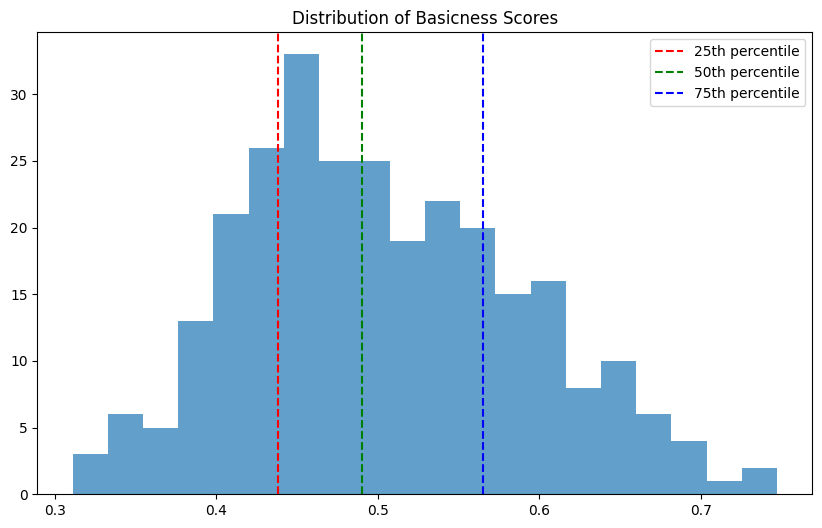

In [23]:
# Plot histogram to visualize distribution
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, alpha=0.7)
plt.axvline(
    np.percentile(scores, 25), color="r", linestyle="--", label="25th percentile"
)
plt.axvline(
    np.percentile(scores, 50), color="g", linestyle="--", label="50th percentile"
)
plt.axvline(
    np.percentile(scores, 75), color="b", linestyle="--", label="75th percentile"
)
plt.legend()
plt.title("Distribution of Basicness Scores")
plt.show()

## Evaluation

### Get human annotations

In [24]:
from src.analysis.agreements import calculate_feature_human_agreement

human_it_annotation_path = (
    "../../data/human_annotations/culture_annotation_datasets_annotated_human_it.csv"
)
human_en_annotation_path = (
    "../../data/human_annotations/culture_annotation_datasets_annotated_human_en.csv"
)
human_es_annotation_path = (
    "../../data/human_annotations/culture_annotation_datasets_annotated_human_es.csv"
)
human_nb_annotation_path = (
    "../../data/human_annotations/culture_annotation_datasets_annotated_human_nb.csv"
)

HUMAN_ANNOTATION_PATHS = {
    "en": human_en_annotation_path,
    "it": human_it_annotation_path,
    "es": human_es_annotation_path,
    "nb": human_nb_annotation_path,
}

# Load human annotations
HUMAN_ANNOTATION_DFS = {
    lang: pd.read_csv(path) for lang, path in HUMAN_ANNOTATION_PATHS.items()
}

### Function to evaluate agreements between features and human annotations for all languages

In [25]:
def evaluate_all_annotations_agreements(
    feature_df: pd.DataFrame, human_annotation_dfs: dict, feature_weights: dict
):
    # print("Used weights:")
    # for key, weight_dict in feature_weights.items():
    #     print(f"\t{key}")
    #     for label, weight in weight_dict.items():
    #         print(f"\t\t{label}: {weight}")
    # print("\n")
    print("--------------------- Agreement ---------------------")
    for lang, human_annotation_df in human_annotation_dfs.items():
        agreements = calculate_feature_human_agreement(
            feature_df, human_annotation_df, f"feature_human_agreement_{lang}", lang
        )
        print(f"--------------------- {lang} ---------------------")
        print(
            f"Cohen Kappa: {agreements['overall']['cohen_kappa']}\nPercent Agreement: {agreements['overall']['percent_agreement']}\nBinary Agreement: {agreements['overall']['binary_agreement']}\nMSE: {agreements['overall']['mse']}"
        )
        print("\n")

### Test on language specific weights derived from correlations

In [27]:
language_specific_weights = analyzer.get_language_specific_weights()

evaluate_all_annotations_agreements(
    all_synsets_lang_syn_df, HUMAN_ANNOTATION_DFS, language_specific_weights
)

--------------------- Agreement ---------------------
Analyzing feature_human_agreement_en with 70 items for language en
--------------------- en ---------------------
Cohen Kappa: 0.3799906059182715
Percent Agreement: 0.6125
Binary Agreement: 0.85
MSE: 0.4625


Analyzing feature_human_agreement_it with 70 items for language it
--------------------- it ---------------------
Cohen Kappa: 0.3638914873713751
Percent Agreement: 0.575
Binary Agreement: 0.8375
MSE: 0.425


Analyzing feature_human_agreement_es with 70 items for language es
--------------------- es ---------------------
Cohen Kappa: 0.05482041587901698
Percent Agreement: 0.1875
Binary Agreement: 0.8375
MSE: 1.1875


Analyzing feature_human_agreement_nb with 70 items for language nb
--------------------- nb ---------------------
Cohen Kappa: 0.4360086767895879
Percent Agreement: 0.5875
Binary Agreement: 0.8875
MSE: 0.6375




### Try Other Weights/Thresholds

In [36]:
# Use fixed thresholds
thresholds = [0.25, 0.5, 0.75]

# Change thresholds array to test with different values

In [37]:
# Literature-based weights
literature_weights = {
    'word_frequency_weight': 1.0,
    'word_length_weight': -1.0,
    'pronounce_complexity_weight': -1.0,
    'n_hyponyms_weight': 0.0,
    'n_synonyms_weight': 0.0,
    'n_senses_weight': 0.0,
    'word_in_children_res_weight': 1.0,
    'word_in_second_lang_learn_res_weight': 1.0,
    'n_syn_senses_weight': 0.0
}

analyzer.set_weights(literature_weights)
analyzer.set_language_specific_weights(None)  # Disable language-specific weights
all_synsets_literature_df = analyzer.analyze_lang_syn_group(
    word=analysis_name + "_literature_weights", thresholds=thresholds
)
evaluate_all_annotations_agreements(
    all_synsets_literature_df, HUMAN_ANNOTATION_DFS, literature_weights
)
# Reset indexes
all_synsets_literature_df = all_synsets_literature_df.reset_index(drop=True)

--------------------- Agreement ---------------------
Analyzing feature_human_agreement_en with 70 items for language en
--------------------- en ---------------------
Cohen Kappa: 0.11087866108786604
Percent Agreement: 0.2875
Binary Agreement: 0.5125
MSE: 1.8875


Analyzing feature_human_agreement_it with 70 items for language it
--------------------- it ---------------------
Cohen Kappa: 0.13405495420482916
Percent Agreement: 0.2375
Binary Agreement: 0.5875
MSE: 1.425


Analyzing feature_human_agreement_es with 70 items for language es
--------------------- es ---------------------
Cohen Kappa: 0.025021570319240793
Percent Agreement: 0.15
Binary Agreement: 0.5
MSE: 2.7375


Analyzing feature_human_agreement_nb with 70 items for language nb
--------------------- nb ---------------------
Cohen Kappa: 0.22461538461538466
Percent Agreement: 0.3125
Binary Agreement: 0.725
MSE: 0.9875




In [38]:
# Uniform weights
uniform_weights = {
    'word_frequency_weight': 1.0,
    'word_length_weight': -1.0,
    'pronounce_complexity_weight': -1.0,
    'n_hyponyms_weight': -1.0,
    'n_synonyms_weight': -1.0,
    'n_senses_weight': -1.0,
    'word_in_children_res_weight': 1.0,
    'word_in_second_lang_learn_res_weight': 1.0,
    'n_syn_senses_weight': -1.0
}

analyzer.set_weights(uniform_weights)
analyzer.set_language_specific_weights(None)  # Disable language-specific weights
all_synsets_uniform_df = analyzer.analyze_lang_syn_group(
    word=analysis_name + "_uniform_weights", thresholds=thresholds
)
evaluate_all_annotations_agreements(
    all_synsets_uniform_df, HUMAN_ANNOTATION_DFS, uniform_weights
)
# Reset indexes
all_synsets_uniform_df = all_synsets_uniform_df.reset_index(drop=True)

--------------------- Agreement ---------------------
Analyzing feature_human_agreement_en with 70 items for language en
--------------------- en ---------------------
Cohen Kappa: 0.07902007736231365
Percent Agreement: 0.1125
Binary Agreement: 0.35
MSE: 3.2125


Analyzing feature_human_agreement_it with 70 items for language it
--------------------- it ---------------------
Cohen Kappa: 0.08188037960715078
Percent Agreement: 0.1625
Binary Agreement: 0.425
MSE: 2.325


Analyzing feature_human_agreement_es with 70 items for language es
--------------------- es ---------------------
Cohen Kappa: 0.009388151505341669
Percent Agreement: 0.025
Binary Agreement: 0.2375
MSE: 4.2375


Analyzing feature_human_agreement_nb with 70 items for language nb
--------------------- nb ---------------------
Cohen Kappa: 0.11704312114989734
Percent Agreement: 0.2125
Binary Agreement: 0.5375
MSE: 1.675




In [ ]:
# Re-enable language-specific weights for further analysis
analyzer.set_language_specific_weights(language_specific_weights)

### Threshold Optimization

In [ ]:
def optimize_thresholds_all_languages(analyzer, scores, step=0.05, languages=None):
    best_avg_kappa = -1
    best_thresholds = None
    best_lang_kappas = {}

    if languages is None:
        languages = ["en", "it", "es", "nb"]  # Default to all available languages

    # Define ranges based on distribution
    min_val, max_val = np.min(scores), np.max(scores)
    range_vals = max_val - min_val

    # Track progress
    total_iterations = (
        len(
            np.arange(
                min_val + 0.1 * range_vals,
                min_val + 0.5 * range_vals,
                step * range_vals,
            )
        )
        * len(np.arange(0.1 * range_vals, 0.8 * range_vals, step * range_vals))
        * len(np.arange(0.1 * range_vals, 0.95 * range_vals, step * range_vals))
    )
    print(f"Starting grid search with ~{total_iterations} iterations...")

    progress_count = 0

    # Generate candidate thresholds
    for t1 in np.arange(
        min_val + 0.1 * range_vals, min_val + 0.5 * range_vals, step * range_vals
    ):
        for t2 in np.arange(
            t1 + 0.1 * range_vals, min_val + 0.8 * range_vals, step * range_vals
        ):
            for t3 in np.arange(
                t2 + 0.1 * range_vals, max_val - 0.05 * range_vals, step * range_vals
            ):
                thresholds = [t1, t2, t3]

                # Update ranked dataframe once per threshold set
                all_synsets_df_with_ranks = analyzer.add_basicness_rank(
                    score_column="basicness_score_experimental", thresholds=thresholds
                )

                # Calculate agreement for each language
                kappas = {}
                for lang in languages:
                    agreements = calculate_feature_human_agreement(
                        all_synsets_df_with_ranks,
                        HUMAN_ANNOTATION_DFS[lang],
                        f"feature_human_agreement_{lang}",
                        lang,
                    )
                    kappas[lang] = agreements["overall"]["cohen_kappa"]

                # Calculate average kappa across languages
                avg_kappa = sum(kappas.values()) / len(kappas)

                if avg_kappa > best_avg_kappa:
                    best_avg_kappa = avg_kappa
                    best_thresholds = thresholds
                    best_lang_kappas = kappas.copy()

                # Show progress every 1000 iterations
                progress_count += 1
                if progress_count % 1000 == 0:
                    print(
                        f"Completed {progress_count} iterations. Current best avg kappa: {best_avg_kappa:.4f}"
                    )

    return best_thresholds, best_avg_kappa, best_lang_kappas


# Optimize thresholds for all languages
best_thresholds, best_avg_kappa, lang_kappas = optimize_thresholds_all_languages(
    analyzer, scores
)
print(f"Best thresholds: {best_thresholds}")
print(f"Best average Cohen Kappa: {best_avg_kappa}")
print("Kappa by language:")
for lang, kappa in lang_kappas.items():
    print(f"  {lang}: {kappa:.4f}")